# Compressive Learning of Generative Networks - Demo notebook
This notebook is a demo of the code used for the paper
> Vincent Schellekens and Laurent Jacques, "Compressive Learning of Generative Networks"

accepted at the [ESANN 2020 conference](https://www.esann.org/).

The goal of this notebook is to show how the simulation results were obtained at the time the paper was submitted. More advanced results, obtained later, will be made available inside other notebooks of the [CL-GN github repository](https://github.com/schellekensv/CL-GN).

### Importing everything we need

In [2]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Import what we need from keras
import keras
from keras.layers import Dense, LeakyReLU
from keras.models import Sequential

We use the `pycle` toolbox for sketching and synthetic datasets generation, for which we provided a frozen copy of the current version (as of 18/02/2020) on this github repo. The latest version of the `pycle` toolbox can be found [here](https://github.com/schellekensv/pycle) (future updates to `pycle`*should* be backwards compatible, but we here use a frozen version, just in case).

In [3]:
import pycle.sketching as sk
import pycle.utils

### Generating the dataset
For this preliminary paper, we used three 2-D synthetic datasets: a Gaussian mixture model (GMM), a spiral, and concentric circles. In the following cell, you can select which dataset will be used.

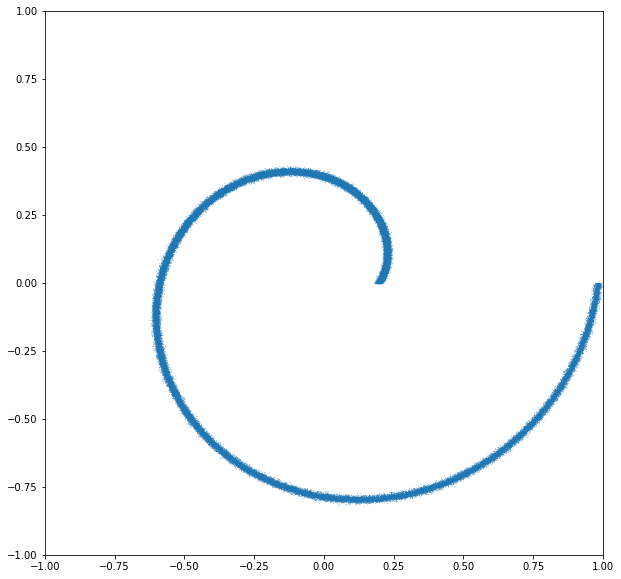

In [4]:
## Generate a synthetic dataset

# Choose the dataset type: use one of the three following lines
#dataset_type = 'GMM'
#dataset_type = 'circle'
dataset_type = 'spiral'

# Define the main parameters of the dataset
d = 2        # Dimension
n = int(1e5) # Number of samples in the dataset 
K = 5 if dataset_type == 'GMM' else 1 # Number of Gaussian modes or circles (not used for the spiral case)

# Actually generate the dataset
if dataset_type == 'GMM':
    X = pycle.utils.generatedataset_GMM(d,K,n,output_required='dataset',balanced=False,normalize='l_2-unit-ball')
elif dataset_type == 'circle':
    X = pycle.utils.generateCirclesDataset(K,n,normalize='l_2-unit-ball')
elif dataset_type == 'spiral':
    X = pycle.utils.generateSpiralDataset(n,normalize='l_2-unit-ball')

# Visualize the generated dataset
plt.figure(figsize=[10,10])
plt.scatter(X[:,0],X[:,1],s=0.01)
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.show()

### Compute the sketch of the dataset
Note that the computation of the sketch is not optimized in this version of `pycle`, since its embarassingly parallelizable nature is not yet exploited.

In [5]:
## Sketch the dataset
# Sketch parameters
sketch_sigma2 = 0.001 # scale of the folded Gaussian distribution
m = 10000             # sketch dimension

# Draw the frequencies
Omega = sk.drawFrequencies('folded_gaussian',d,m,sketch_sigma2*np.eye(d))

# Create the sketching operator
Phi = sk.SimpleFeatureMap('complexExponential',Omega,c_norm='unit')

# Actual sketching
z = sk.computeSketch(X,Phi)

# Helpful for later: sketch where we stack the real and imaginary components
z_stack = np.concatenate([z.real,z.imag],axis=0)

Optional step: we visualize the sketched representation of the density of the dataset by plotting $f(\boldsymbol c) = -\langle \boldsymbol z, \Phi(\boldsymbol c) \rangle$ as a function of $\boldsymbol c$. Intuitively, $f(\boldsymbol c)$ can be thought of as how the sketch visualizes the distribution of the data.
This allows us to check if the sketching parameters (such as $\sigma^2$ and $m$) are chosen such that the sketch retains enough information to be able to hope that the netork will learn something useful. We plot some values of the dataset on top of it for easy comparison.

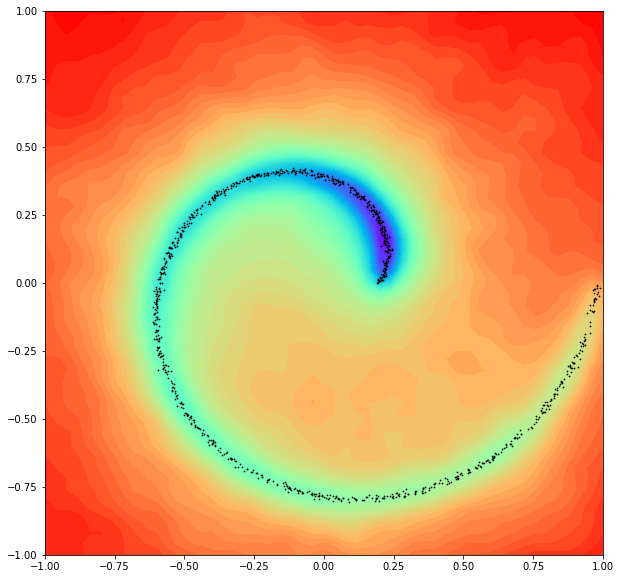

In [6]:
# Intuitive check
def _f(c,z):
    return -np.real(np.vdot(Phi(c),z))

# Grid over [-1,1]^2
n_grid = 51
xx = np.linspace(-1,1,n_grid)
yy = np.linspace(-1,1,n_grid)
f_values = np.zeros((n_grid,n_grid))
XX, YY = np.meshgrid(xx, yy)

# Loop over the grid
for ix in range(n_grid):
    for iy in range(n_grid):
        c = np.array([XX[ix,iy],YY[ix,iy]])
        f_values[ix][iy] = _f(c,z)

# Plot f(c)
plt.figure(figsize=[10,10])
plt.contourf(XX, YY, f_values, 55, cmap=plt.cm.rainbow)
plt.scatter(X[:1000,0],X[:1000,1],s=0.5,c='k')
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.show()

### Build a generative network with keras
We used a "vanilla" architecture. It's probable that for this simple toy example almost any network will do the job.

In [7]:
## Build the network

# Network parameters
number_layers = 7
hidden_units = 10
leaky_relu_slope = 0.2
latent_space_dimension = 10

# First layer
generator = Sequential()
generator.add(Dense(units=hidden_units,input_dim=latent_space_dimension))
generator.add(LeakyReLU(leaky_relu_slope))

# Hidden layers (they are all the same)
for i in range(number_layers - 1):
    generator.add(Dense(units=hidden_units))
    generator.add(LeakyReLU(leaky_relu_slope))

# Output layer
generator.add(Dense(units=2))

# Look at it
generator.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 10)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                110       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 10)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                110       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 10)                0         
_________________________________________________________________
dens

### Define the loss function and optimization algorithm

In [9]:
## Define the loss thanks to the sketch (! sketch must be computed before)
# See https://towardsdatascience.com/advanced-keras-constructing-complex-custom-losses-and-metrics-c07ca130a618

import keras.backend as K
Ot = K.variable(Omega.T) 

# To compute the sketch of generated samples
def computeSketch_with_backend(y,Omt):
    arg = K.dot(Ot,K.transpose(y))
    return K.mean(K.concatenate([K.cos(arg),K.sin(arg)],axis=0),axis=1)/np.sqrt(m)

# The loss
def loss_MMD_withSketch(y_true, y_pred, squared=False):
    z_generated = computeSketch_with_backend(y_pred,Ot) # sketch of the generated data
    loss = K.sum(K.square(z_stack - z_generated)) # Squared l_2 distance of the sketches
    return loss if not squared else K.sqrt(loss)

# Vanilla adam optimizer
generator.compile(loss=loss_MMD_withSketch, optimizer='adam', metrics=[])

### Training

In [10]:
# Generate noisy latent space vectors
n_gen = 100000
Z_train = np.random.normal(loc=0, scale=1, size=[n_gen, latent_space_dimension]) # Standard gaussian
_dummy_label = np.zeros(Z_train.shape) # Fake target, the loss we defined doesn't use it

# Early stopping callback object, detects lack of training progress
from keras.callbacks import EarlyStopping
delta_MMD_stop = 0.0005 # Designed for the MMD, not MMD squared
es = EarlyStopping(monitor='loss', min_delta = delta_MMD_stop, patience = 2, mode='min', verbose=1)

In [12]:
# And launch the training!
hist = generator.fit(Z_train, _dummy_label, batch_size=1000, epochs=25, verbose=1, callbacks=[es])

Epoch 1/25
100000/100000 [==============================] - 49s - loss: 0.2691    
Epoch 2/25
100000/100000 [==============================] - 52s - loss: 0.1770    
Epoch 3/25
100000/100000 [==============================] - 54s - loss: 0.1517    
Epoch 4/25
100000/100000 [==============================] - 55s - loss: 0.1311    
Epoch 5/25
100000/100000 [==============================] - 58s - loss: 0.1092    
Epoch 6/25
100000/100000 [==============================] - 56s - loss: 0.0941    
Epoch 7/25
100000/100000 [==============================] - 56s - loss: 0.0858    
Epoch 8/25
100000/100000 [==============================] - 56s - loss: 0.0801    
Epoch 9/25
100000/100000 [==============================] - 56s - loss: 0.0763    
Epoch 10/25
100000/100000 [==============================] - 57s - loss: 0.0730    
Epoch 11/25
100000/100000 [==============================] - 56s - loss: 0.0696    
Epoch 12/25
100000/100000 [==============================] - 56s - loss: 0.0662    
E

On our toy examples, we usually got relatively good results when the loss was $\leq 0.04$ for a batchsize of $1000$ (you might want to continue training if this is not the case, maybe play with the batchsize or even re-initializing the network weights if you're stuck in a bad local optimum).

We now visualize the samples that our network generates, using new latent space vectors.

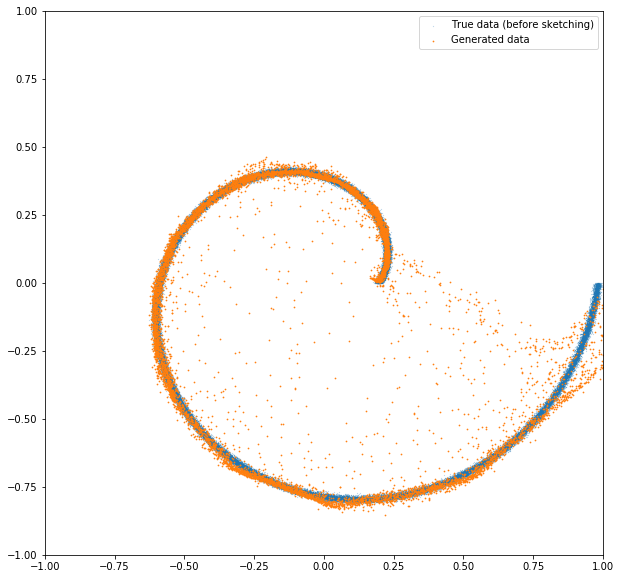

In [13]:
n_test = 50000
Z_test = np.random.normal(loc=0, scale=1, size=[n_test, latent_space_dimension])
X_test = generator.predict(Z_test)

plt.figure(figsize=(10,10))
plt.scatter(X[:,0],X[:,1],s=0.01)
plt.scatter(X_test[:10000,0],X_test[:10000,1],s=0.5)
plt.legend(['True data (before sketching)','Generated data'])
plt.xlim([-1,1])
plt.ylim([-1,1])
plt.show()

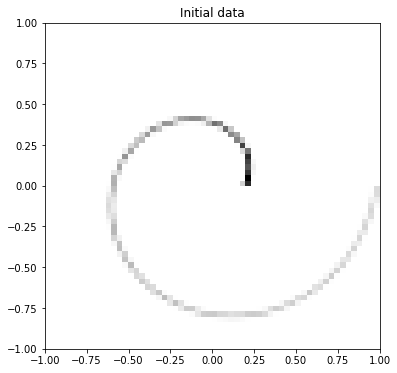

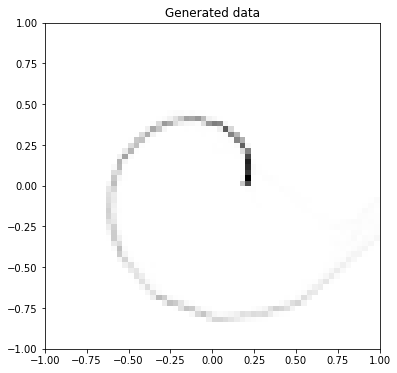

In [14]:
# Compare with 2-D histograms
bins = 60

plt.figure(figsize=(6,6))
plt.hist2d(X[:,0], X[:,1], bins, range=[[-1,1],[-1,1]], density=True, cmap='Greys')
plt.title('Initial data')
plt.show()

plt.figure(figsize=(6,6))
plt.hist2d(X_test[:,0], X_test[:,1], bins, range=[[-1,1],[-1,1]], density=True, cmap='Greys')
plt.title('Generated data')
plt.show()

In [ ]:
# With Power law normalization of colors
import matplotlib.colors as mcolors
gamma = 0.5
bins = 150

plt.figure(figsize=(6,6))
plt.hist2d(X[:,0], X[:,1], bins, range=[[-1,1],[-1,1]], density=True, cmap='Greys', norm=mcolors.PowerNorm(gamma))
plt.title('Initial data')
plt.show()

plt.figure(figsize=(6,6))
plt.hist2d(X_test[:,0], X_test[:,1], bins, range=[[-1,1],[-1,1]], density=True, cmap='Greys', norm=mcolors.PowerNorm(gamma))
plt.title('Generated data')
plt.show()